In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 500
trials=100
skip_boot=True
skip_shi=True
refinement_test=True
cstar1=.02
cstar2 = .1
linspace=10
smoothing =2

# Size stuff

In [4]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar1)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])



[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.922 0.    0.078] [1. 0. 0.] [1. 0. 0.]
[0.852 0.002 0.146] [0.998 0.002 0.   ] [0.958 0.    0.042]
[0.908 0.006 0.086] [0.994 0.006 0.   ] [0.94 0.   0.06]
[0.922 0.006 0.072] [0.948 0.006 0.046] [0.954 0.004 0.042]
[0.934 0.008 0.058] [0.934 0.008 0.058] [0.95  0.006 0.044]
[0.946 0.    0.054] [0.946 0.    0.054] [0.962 0.    0.038]
[0.944 0.004 0.052] [0.944 0.004 0.052] [0.956 0.004 0.04 ]
[0.94  0.012 0.048] [0.94  0.012 0.048] [0.956 0.01  0.034]
[0.944 0.016 0.04 ] [0.944 0.016 0.04 ] [0.958 0.01  0.032]


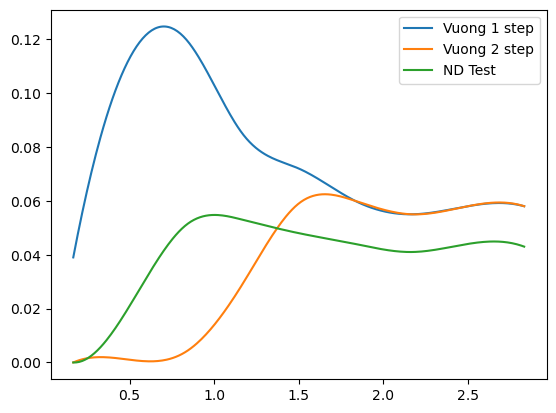

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 step')
    plt.plot(params_new, interp(1-results2[:,2,0]) ,label='ND Test')
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('figs/'+name,dpi=300)
    plt.show()

name = 'size1_nims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar1)
create_fig(betas,results,name=name)

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.938 0.    0.062] [1. 0. 0.] [1. 0. 0.]
[0.884 0.002 0.114] [0.998 0.002 0.   ] [1. 0. 0.]
[0.916 0.006 0.078] [0.994 0.006 0.   ] [1. 0. 0.]
[0.916 0.012 0.072] [0.934 0.012 0.054] [0.998 0.    0.002]
[0.938 0.006 0.056] [0.938 0.006 0.056] [0.998 0.002 0.   ]
[0.944 0.022 0.034] [0.944 0.022 0.034] [0.992 0.002 0.006]
[0.92  0.014 0.066] [0.92  0.014 0.066] [0.994 0.    0.006]
[0.954 0.008 0.038] [0.954 0.008 0.038] [0.992 0.    0.008]
[0.938 0.012 0.05 ] [0.938 0.012 0.05 ] [0.984 0.002 0.014]


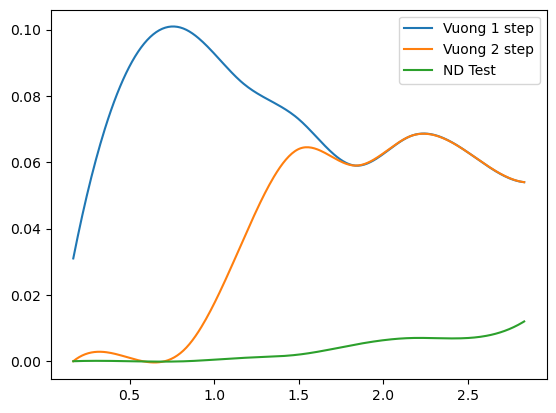

In [6]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    
name = 'size2_nims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar2)
create_fig(betas,results,name=name)

# alternate DGP

In [7]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y


def setup_shi2(yn,xn,return_model=False,num_params=4):
    x1n,x2n = xn[:,0],xn[:,1:num_params]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    
    model1_deriv = OLS_loglike(yn,sm.add_constant(x1n))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    grad1 =  model1_deriv.score_obs(model1_fit.params)    
    hess1 = model1_deriv.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    params2 = (model2_fit.params)
    
    model2_deriv = OLS_loglike(yn,sm.add_constant(x2n))
    ll2 = model2_deriv.loglikeobs(model2_fit.params)
    grad2 =  model2_deriv.score_obs(model2_fit.params)    
    hess2 = model2_deriv.hessian(model2_fit.params)
    
    if return_model:
        return ll1,grad1,hess1,params1,model1,ll2,grad2,hess2,params2,model2
    return ll1,grad1,hess1,params1,ll2,grad2,hess2,params2

def gen_data2(nobs=1000, a=0.25, num_params=4):
    x = np.random.normal(scale=1., size=(nobs,1+num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*x[:,0] + a/np.sqrt(num_params)*x[:,1:num_params+1].sum(axis=1) + e
    return y,x,nobs

yn,xn,nobs = gen_data2()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi2(yn,xn,return_model=False,num_params=15)
print(grad1.shape,hess1.shape)

(1000, 2) (2, 2)


[0.92 0.   0.08] [0.996 0.    0.004] [0.944 0.    0.056]
[0.906 0.    0.094] [0.936 0.    0.064] [0.924 0.    0.076]
[0.952 0.008 0.04 ] [0.952 0.008 0.04 ] [0.964 0.004 0.032]
[0.928 0.032 0.04 ] [0.928 0.032 0.04 ] [0.934 0.028 0.038]
[0.938 0.03  0.032] [0.938 0.03  0.032] [0.942 0.026 0.032]
[0.936 0.026 0.038] [0.936 0.026 0.038] [0.946 0.022 0.032]
[0.932 0.036 0.032] [0.932 0.036 0.032] [0.934 0.034 0.032]
[0.93 0.04 0.03] [0.93 0.04 0.03] [0.934 0.036 0.03 ]
[0.938 0.038 0.024] [0.938 0.038 0.024] [0.946 0.034 0.02 ]
[0.94  0.034 0.026] [0.94  0.034 0.026] [0.946 0.028 0.026]


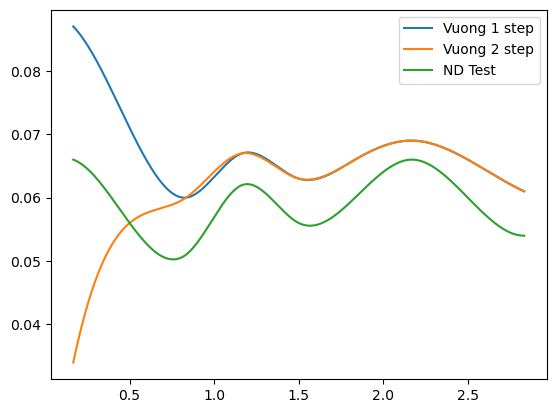

In [8]:
a = np.linspace(0,3,linspace)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar1)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'size3_nims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar1)
create_fig(a,results,name=name)

[0.922 0.    0.078] [1. 0. 0.] [0.986 0.    0.014]
[0.892 0.004 0.104] [0.936 0.    0.064] [0.966 0.    0.034]
[0.924 0.008 0.068] [0.924 0.008 0.068] [0.96  0.002 0.038]
[0.936 0.02  0.044] [0.936 0.02  0.044] [0.964 0.014 0.022]
[0.91  0.038 0.052] [0.91  0.038 0.052] [0.94  0.026 0.034]
[0.904 0.05  0.046] [0.904 0.05  0.046] [0.942 0.034 0.024]
[0.92  0.042 0.038] [0.92  0.042 0.038] [0.944 0.034 0.022]
[0.934 0.046 0.02 ] [0.934 0.046 0.02 ] [0.956 0.032 0.012]
[0.938 0.044 0.018] [0.938 0.044 0.018] [0.964 0.028 0.008]
[0.942 0.03  0.028] [0.942 0.03  0.028] [0.964 0.018 0.018]


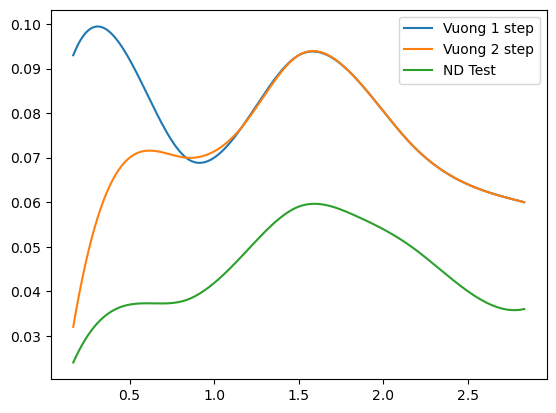

In [9]:
a = np.linspace(0,3,linspace)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


name = 'size4_nims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar2)
create_fig(a,results,name=name)

# Power stuff

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.974 0.    0.026] [1. 0. 0.] [1. 0. 0.]
[0.736 0.002 0.262] [0.998 0.002 0.   ] [0.994 0.002 0.004]
[0.46 0.   0.54] [1. 0. 0.] [0.786 0.    0.214]
[0.222 0.    0.778] [1. 0. 0.] [0.364 0.    0.636]
[0.058 0.    0.942] [0.98 0.   0.02] [0.112 0.    0.888]
[0.018 0.    0.982] [0.916 0.    0.084] [0.032 0.    0.968]
[0.002 0.    0.998] [0.916 0.    0.084] [0.006 0.    0.994]
[0. 0. 1.] [0.88 0.   0.12] [0. 0. 1.]
[0. 0. 1.] [0.876 0.    0.124] [0. 0. 1.]


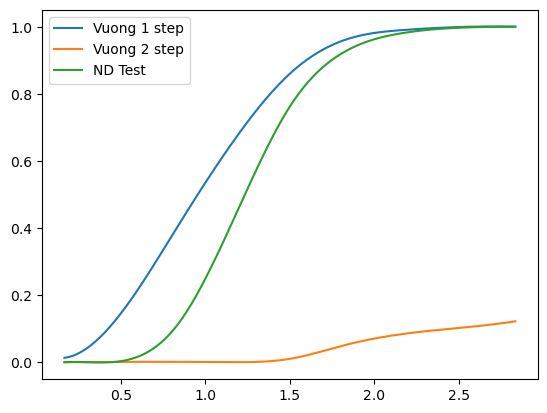

In [10]:

def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar1)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nsims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar1)
create_fig(betas,results,name=name)

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.976 0.    0.024] [1. 0. 0.] [1. 0. 0.]
[0.72 0.   0.28] [1. 0. 0.] [1. 0. 0.]
[0.452 0.    0.548] [1. 0. 0.] [1. 0. 0.]
[0.16 0.   0.84] [1. 0. 0.] [0.99 0.   0.01]
[0.066 0.    0.934] [0.976 0.    0.024] [0.85 0.   0.15]
[0.008 0.    0.992] [0.932 0.    0.068] [0.428 0.    0.572]
[0. 0. 1.] [0.908 0.    0.092] [0.114 0.    0.886]
[0. 0. 1.] [0.892 0.    0.108] [0.012 0.    0.988]
[0. 0. 1.] [0.83 0.   0.17] [0.004 0.    0.996]


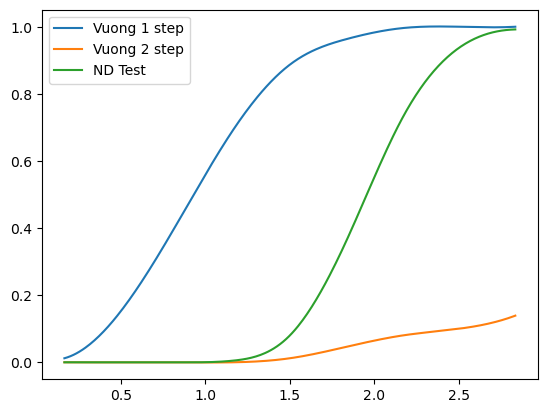

In [11]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,cstar0=cstar2)
    reg,twostep, refine_test,boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nsims%s_shi%s_cstar%s.png'%(nsims,skip_shi,cstar2)
create_fig(betas,results,name=name)